# Ultrasound Nerve Segmentation

In [1]:
import os
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.utils.data import DataLoader, sampler
from torchvision import transforms as T

from PIL import Image

from matplotlib import pyplot as plt
%matplotlib inline

from datetime import datetime

from usns import *

In [117]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [184]:
DATA_PATH = 'data/'
MODEL_PATH = 'models/'
SUBMS_PATH = 'submissions/'

data_shape = (420, 580)

if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

## View all points where mask appears in train dataset

In [89]:
def show_all_masks():
    dpath = os.path.join(DATA_PATH, 'train')
    mask_list = [name for name in os.listdir(dpath) if 'mask' in name]
    
    acc_img = np.zeros(data_shape, dtype='uint64')
    ii = 0
    for fname in mask_list:
        img = Image.open(os.path.join(dpath, fname))
        img = np.array(img)
        img = img // 255
        acc_img += img
        ii += 1
    
    acc_img = (acc_img > 0) * 1
#     acc_img = acc_img / ii
    
    plt.imshow(acc_img)
    return acc_img
    
im = show_all_masks()

CalledProcessError: Command 'b"def show_all_masks():\n    dpath = os.path.join(DATA_PATH, 'train')\n    mask_list = [name for name in os.listdir(dpath) if 'mask' in name]\n    \n    acc_img = np.zeros(data_shape, dtype='uint64')\n    ii = 0\n    for fname in mask_list:\n        img = Image.open(os.path.join(dpath, fname))\n        img = np.array(img)\n        img = img // 255\n        acc_img += img\n        ii += 1\n    \n    acc_img = (acc_img > 0) * 1\n#     acc_img = acc_img / ii\n    \n    plt.imshow(acc_img)\n    return acc_img\n    \nim = show_all_masks()\n"' returned non-zero exit status 1.

## Data preparation

Trying to train model only on samples with labels.
After this we will try to additional layers to detect if there is a nerve on the image

In [101]:
# Creating links in dedicated folder on images only containing labeled nerve
def symlink_labeled(labeled_path):
    try:
        os.mkdir(labeled_path)
    except FileExistsError:
        print('Directory is already exists')
    
    train_path = os.path.join(DATA_PATH, 'train')
    rel_train_path = os.path.relpath(train_path, labeled_path)
    for imgname in os.listdir(train_path):
        if 'mask' not in imgname:
            maskname = imgname.replace('.tif', '_mask.tif')
            mask = Image.open(os.path.join(train_path, maskname))
            if np.array(mask).any():
                os.symlink(os.path.join(rel_train_path, imgname),
                           os.path.join(labeled_path, imgname))
                os.symlink(os.path.join(rel_train_path, maskname),
                           os.path.join(labeled_path, maskname))

symlink_labeled(os.path.join(DATA_PATH, 'labeled'))

## Training Unet model

Firstly, training only on labeled data

In [174]:
params = {
    'batch_size': 2,
    'num_train': 2000
}

In [175]:
trainset = USNSDataset(os.path.join(DATA_PATH, 'labeled'), train=True, transform=transform, mask_transform=transform_mask)

loader_train = DataLoader(trainset, batch_size=params['batch_size'],
                          sampler=sampler.SubsetRandomSampler(range(params['num_train'])))
loader_val = DataLoader(trainset, batch_size=params['batch_size'],
                        sampler=sampler.SubsetRandomSampler(range(params['num_train'], trainset.__len__())))

In [176]:
unet = Unet(n_filters=64)
unet = unet.to(device=device);

Iteration 99, loss = 0.06987969107933631
Validation loss = 0.08951639438010542

Iteration 199, loss = 0.06430270137007325
Validation loss = 0.05137635563679592

Iteration 299, loss = 0.0930648969019005
Validation loss = 0.08754642222000739

Iteration 399, loss = 0.07437967691961785
Validation loss = 0.048440441973814745

Iteration 499, loss = 0.07252631274954237
Validation loss = 0.05807345074556396

Iteration 599, loss = 0.056573283277720494
Validation loss = 0.058865698297078495

Iteration 699, loss = 0.0700560991092967
Validation loss = 0.045051887961357666

Iteration 799, loss = 0.05570990558512634
Validation loss = 0.03879513103339876

Iteration 899, loss = 0.0803791210813919
Validation loss = 0.061017795750253734

Iteration 999, loss = 0.05923288436214976
Validation loss = 0.03751282556637016

After 1 epochs: loss = 0.05923288436214976
Validation loss = 0.05490225051611933


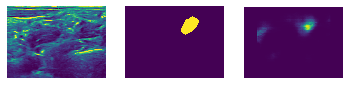


Iteration 99, loss = 0.045509405082178774
Validation loss = 0.034688922852517665

Iteration 199, loss = 0.07047870351003492
Validation loss = 0.10202148341133986

Iteration 299, loss = 0.04265048905298561
Validation loss = 0.051509792858055944

Iteration 399, loss = 0.08520215746315316
Validation loss = 0.07306948158104395

Iteration 499, loss = 0.0731945198852216
Validation loss = 0.07277090413125074

Iteration 599, loss = 0.03769099747875142
Validation loss = 0.04964746857302224

Iteration 699, loss = 0.06731005396868535
Validation loss = 0.09717764307995763

Iteration 799, loss = 0.04694768994217967
Validation loss = 0.09114580966897157

Iteration 899, loss = 0.06251084653651656
Validation loss = 0.12583532492186517

Iteration 999, loss = 0.04240646936531095
Validation loss = 0.05448541478524197

After 2 epochs: loss = 0.04240646936531095
Validation loss = 0.05385482658864191


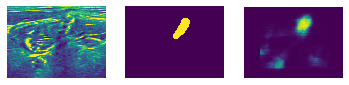


Iteration 99, loss = 0.11251842478444644
Validation loss = 0.03496598718002061

Iteration 199, loss = 0.060505655083988426
Validation loss = 0.04830919284741434

Iteration 299, loss = 0.11936244580466403
Validation loss = 0.06312318320807925

Iteration 399, loss = 0.06633879162950249
Validation loss = 0.1454861422770336

Iteration 499, loss = 0.11135601591715508
Validation loss = 0.077958382798795

Iteration 599, loss = 0.06347287865540092
Validation loss = 0.04402084625840719

Iteration 699, loss = 0.06581656547155927
Validation loss = 0.061901908244785905

Iteration 799, loss = 0.03495432834971732
Validation loss = 0.1687323658511168

Iteration 899, loss = 0.05733740840603452
Validation loss = 0.11842593664550252

Iteration 999, loss = 0.06867213773777273
Validation loss = 0.08078807902429205

After 3 epochs: loss = 0.06867213773777273
Validation loss = 0.09009471807430723


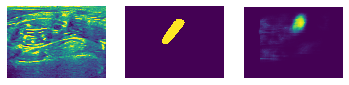


Iteration 99, loss = 0.0561764090378925
Validation loss = 0.07062742822832623

Iteration 199, loss = 0.05252138724767501
Validation loss = 0.041652018808629204

Iteration 299, loss = 0.03641956637391812
Validation loss = 0.08953213916757446

Iteration 399, loss = 0.07376407585604879
Validation loss = 0.04739135973909677

Iteration 499, loss = 0.0882210195586286
Validation loss = 0.0497710865215926

Iteration 599, loss = 0.04581072781239464
Validation loss = 0.07551990403127098

Iteration 699, loss = 0.048619738996575956
Validation loss = 0.038786311699279534

Iteration 799, loss = 0.05886551549752204
Validation loss = 0.05572601884707277

Iteration 899, loss = 0.0470226584453201
Validation loss = 0.06046960007784974

Iteration 999, loss = 0.10408949061803101
Validation loss = 0.08678282994004936

After 4 epochs: loss = 0.10408949061803101
Validation loss = 0.05760321244097896


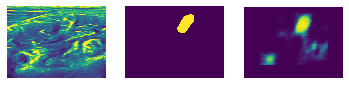


Iteration 99, loss = 0.050596220345786966
Validation loss = 0.07553140961599188

Iteration 199, loss = 0.11473467408121245
Validation loss = 0.0428561844057377

Iteration 299, loss = 0.06821033488892998
Validation loss = 0.03540151966309528

Iteration 399, loss = 0.07020154772129356
Validation loss = 0.07333442014371125

Iteration 499, loss = 0.04481786972150711
Validation loss = 0.03200160346758203

Iteration 599, loss = 0.04784610934498576
Validation loss = 0.09685739430142885

Iteration 699, loss = 0.08228141928908918
Validation loss = 0.07411351330026567

Iteration 799, loss = 0.049788283257376775
Validation loss = 0.042112315328496124

Iteration 899, loss = 0.034596201459662974
Validation loss = 0.18590014604844157

Iteration 999, loss = 0.06706676972044173
Validation loss = 0.09516053481229624

After 5 epochs: loss = 0.06706676972044173
Validation loss = 0.06450252042653959


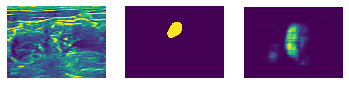


Iteration 99, loss = 0.08056285538393856
Validation loss = 0.03601246217577537

Iteration 199, loss = 0.07525951753357461
Validation loss = 0.033411466051428744

Iteration 299, loss = 0.03766915071945988
Validation loss = 0.023777730259607686

Iteration 399, loss = 0.12552757413698307
Validation loss = 0.04797118381852239

Iteration 499, loss = 0.06729208222659823
Validation loss = 0.12858527349476445

Iteration 599, loss = 0.06838580036182518
Validation loss = 0.03579927374745148

Iteration 699, loss = 0.06685906182900403
Validation loss = 0.035602154620360975

Iteration 799, loss = 0.038752937661000526
Validation loss = 0.03437761758559186

Iteration 899, loss = 0.07867700073049806
Validation loss = 0.0270988340200903

Iteration 999, loss = 0.06158666899565679
Validation loss = 0.029751683456140324

After 6 epochs: loss = 0.06158666899565679
Validation loss = 0.047568680572731274


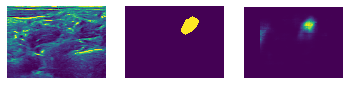


Iteration 99, loss = 0.025762069934693002
Validation loss = 0.10875554061572146

Iteration 199, loss = 0.033870871099868256
Validation loss = 0.13328490640674184

Iteration 299, loss = 0.05669206920893287
Validation loss = 0.1027048739943663

Iteration 399, loss = 0.08979820551950721
Validation loss = 0.11679007254446304

Iteration 499, loss = 0.04868343775930421
Validation loss = 0.09933839695925588

Iteration 599, loss = 0.06494072261418461
Validation loss = 0.09068308838266227

Iteration 699, loss = 0.034951495885737156
Validation loss = 0.14211701674349436

Iteration 799, loss = 0.05022638388526922
Validation loss = 0.03435760183187227

Iteration 899, loss = 0.03456670606992871
Validation loss = 0.07774919010189092

Iteration 999, loss = 0.031214904930954624
Validation loss = 0.16528469981505123

After 7 epochs: loss = 0.031214904930954624
Validation loss = 0.061301449725266244


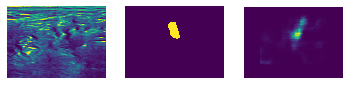


Iteration 99, loss = 0.050339259260411814
Validation loss = 0.0472857657554422

Iteration 199, loss = 0.048977802388031205
Validation loss = 0.029133159165311562

Iteration 299, loss = 0.03608326123694097
Validation loss = 0.07441835097715947

Iteration 399, loss = 0.07489880671359862
Validation loss = 0.07921689923401644

Iteration 499, loss = 0.07084891651632795
Validation loss = 0.051639171331536386

Iteration 599, loss = 0.050435893469330695
Validation loss = 0.1533526159365266

Iteration 699, loss = 0.07223174926756931
Validation loss = 0.044596577318478596

Iteration 799, loss = 0.07636037466141549
Validation loss = 0.028464201952662145

Iteration 899, loss = 0.04329252334521915
Validation loss = 0.07396202738133399

Iteration 999, loss = 0.04391457836231212
Validation loss = 0.07619671625438466

After 8 epochs: loss = 0.04391457836231212
Validation loss = 0.07456871663468786


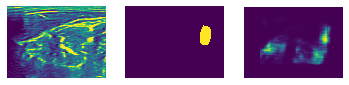


Iteration 99, loss = 0.04818472056388839
Validation loss = 0.03380759467625848

Iteration 199, loss = 0.0452796838653703
Validation loss = 0.040463200762745996

Iteration 299, loss = 0.04333597494139902
Validation loss = 0.09963866172857089

Iteration 399, loss = 0.06000689955217806
Validation loss = 0.06001861654819021

Iteration 499, loss = 0.0502042746631444
Validation loss = 0.06790317737922993

Iteration 599, loss = 0.02854448907677502
Validation loss = 0.027524688475560246

Iteration 699, loss = 0.08268957535939915
Validation loss = 0.01776275464613921

Iteration 799, loss = 0.062005771296800946
Validation loss = 0.03613651624082865

Iteration 899, loss = 0.04839681750730007
Validation loss = 0.10313551592005439

Iteration 999, loss = 0.04946804073577972
Validation loss = 0.0254424505648923

After 9 epochs: loss = 0.04946804073577972
Validation loss = 0.07652424387945231


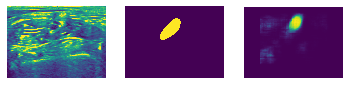


Iteration 99, loss = 0.023712730270320725
Validation loss = 0.06407727013667884

Iteration 199, loss = 0.06764937122270977
Validation loss = 0.02258605397853547

Iteration 299, loss = 0.030195932331872444
Validation loss = 0.02949231511640611

Iteration 399, loss = 0.04969476896002378
Validation loss = 0.0492187684973323

Iteration 499, loss = 0.04967248015353593
Validation loss = 0.04559153136257494

Iteration 599, loss = 0.033108121543102914
Validation loss = 0.06644967589447578

Iteration 699, loss = 0.07598522419957551
Validation loss = 0.1234288463601597

Iteration 799, loss = 0.055842552637450846
Validation loss = 0.03998603025044099

Iteration 899, loss = 0.061286630779448
Validation loss = 0.04510544101699654

Iteration 999, loss = 0.04711490521823823
Validation loss = 0.06936494947938594

After 10 epochs: loss = 0.04711490521823823
Validation loss = 0.0680798732120842


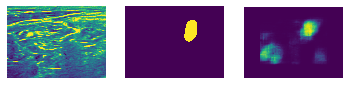


Iteration 99, loss = 0.019872779989782145
Validation loss = 0.08571292717639549

Iteration 199, loss = 0.044989790728397844
Validation loss = 0.11334609268123039

Iteration 299, loss = 0.07755684688991002
Validation loss = 0.13027287974989682

Iteration 399, loss = 0.05847322286448289
Validation loss = 0.03006456340771481

Iteration 499, loss = 0.03127819218747382
Validation loss = 0.12839117387561536

Iteration 599, loss = 0.037184613391629706
Validation loss = 0.06598063556052845

Iteration 699, loss = 0.06717082913028698
Validation loss = 0.053866093052743105

Iteration 799, loss = 0.03229022820769142
Validation loss = 0.039839037506451146

Iteration 899, loss = 0.03904612714552562
Validation loss = 0.029203498492494

Iteration 999, loss = 0.03298347580755918
Validation loss = 0.020190520007597988

After 11 epochs: loss = 0.03298347580755918
Validation loss = 0.07280364663295297


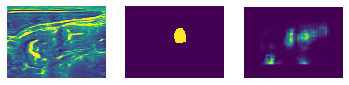


Iteration 99, loss = 0.06461822999665091
Validation loss = 0.032267235061420325

Iteration 199, loss = 0.05986493638654514
Validation loss = 0.05114563621984164

Iteration 299, loss = 0.04415582083100707
Validation loss = 0.06945033454451098

Iteration 399, loss = 0.03283470126459544
Validation loss = 0.057343831037893214

Iteration 499, loss = 0.05631009128743428
Validation loss = 0.05257678839514622

Iteration 599, loss = 0.07359913166335867
Validation loss = 0.03317141512152652

Iteration 699, loss = 0.034750520705343346
Validation loss = 0.14106745844618168

Iteration 799, loss = 0.03256524006737872
Validation loss = 0.038887258395082044

Iteration 899, loss = 0.05035962525847676
Validation loss = 0.03774381787853649

Iteration 999, loss = 0.036022822984042635
Validation loss = 0.020106259570328026

After 12 epochs: loss = 0.036022822984042635
Validation loss = 0.03444096830200202


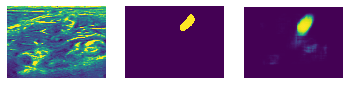


Iteration 99, loss = 0.016908000444277763
Validation loss = 0.08441234708041509

Iteration 199, loss = 0.025249314767592377
Validation loss = 0.03838631734555123

Iteration 299, loss = 0.031032853132633268
Validation loss = 0.021542130681492203

Iteration 399, loss = 0.02973310583939394
Validation loss = 0.016138257224708585

Iteration 499, loss = 0.13979138133792865
Validation loss = 0.024909875303086946

Iteration 599, loss = 0.0886941015273627
Validation loss = 0.06653272447207316

Iteration 699, loss = 0.022715927815301445
Validation loss = 0.03245398690780721

Iteration 799, loss = 0.1072946781287572
Validation loss = 0.0377206723809833

Iteration 899, loss = 0.035092722411637224
Validation loss = 0.029685500641656985

Iteration 999, loss = 0.07259835606826952
Validation loss = 0.07050015626130786

After 13 epochs: loss = 0.07259835606826952
Validation loss = 0.04242074027828263


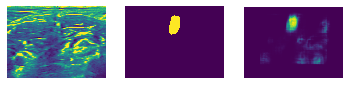


Iteration 99, loss = 0.1471610995163127
Validation loss = 0.021118141574197186

Iteration 199, loss = 0.035544678477834955
Validation loss = 0.02939823493272783

Iteration 299, loss = 0.02846293869457274
Validation loss = 0.04434955485758452

Iteration 399, loss = 0.09311733003832363
Validation loss = 0.06615008556006328

Iteration 499, loss = 0.048678483406510986
Validation loss = 0.02137029725805548

Iteration 599, loss = 0.053040635479927975
Validation loss = 0.09720793134853452

Iteration 699, loss = 0.06046708422246042
Validation loss = 0.019013259000656445

Iteration 799, loss = 0.08306986768378263
Validation loss = 0.04924526605609985

Iteration 899, loss = 0.03076407767253502
Validation loss = 0.1427152908336099

Iteration 999, loss = 0.0332380698192487
Validation loss = 0.030123136222370103

After 14 epochs: loss = 0.0332380698192487
Validation loss = 0.09657375101510497


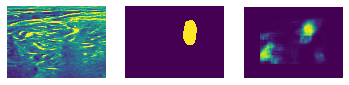


Iteration 99, loss = 0.042975566911242
Validation loss = 0.014799167570431744

Iteration 199, loss = 0.022648295393182492
Validation loss = 0.020974592493238315

Iteration 299, loss = 0.0358674837392443
Validation loss = 0.02269684237978622

Iteration 399, loss = 0.01845411646604926
Validation loss = 0.02720797973560043

Iteration 499, loss = 0.04551333901626208
Validation loss = 0.022948605249739695

Iteration 599, loss = 0.05842174416384962
Validation loss = 0.019961256622201863

Iteration 699, loss = 0.0423970748666578
Validation loss = 0.10018250344029092

Iteration 799, loss = 0.05749464315005353
Validation loss = 0.06134047736965402

Iteration 899, loss = 0.0875034413821704
Validation loss = 0.026926036898923623

Iteration 999, loss = 0.03893083149877585
Validation loss = 0.01742196169125829

After 15 epochs: loss = 0.03893083149877585
Validation loss = 0.042228786547813785


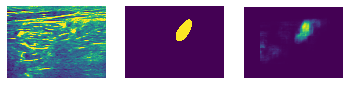


Iteration 99, loss = 0.04766161138825495
Validation loss = 0.11439471817746988

Iteration 199, loss = 0.054229000076226254
Validation loss = 0.030074242765631445

Iteration 299, loss = 0.03944409801830244
Validation loss = 0.10166166023803117

Iteration 399, loss = 0.037856965154272615
Validation loss = 0.02848129621840347

Iteration 499, loss = 0.08916268704290918
Validation loss = 0.020687318011039985

Iteration 599, loss = 0.07226524141708313
Validation loss = 0.02879593716579441

Iteration 699, loss = 0.053735032380515454
Validation loss = 0.027723090639150936

Iteration 799, loss = 0.033631613684891426
Validation loss = 0.024257242534896997

Iteration 899, loss = 0.025339651745083076
Validation loss = 0.02194056183784502

Iteration 999, loss = 0.03929991972820318
Validation loss = 0.04220776111141065

After 16 epochs: loss = 0.03929991972820318
Validation loss = 0.0764878273630787


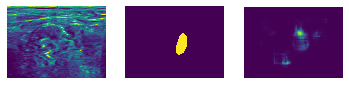


Iteration 99, loss = 0.044114989291167264
Validation loss = 0.06084378444346786

Iteration 199, loss = 0.05068713520620175
Validation loss = 0.018108717568395737

Iteration 299, loss = 0.04693758890837878
Validation loss = 0.03186541790647728

Iteration 399, loss = 0.031035046698583015
Validation loss = 0.022914986859966485

Iteration 499, loss = 0.03243754603130162
Validation loss = 0.10554103158149256

Iteration 599, loss = 0.030150187047679224
Validation loss = 0.023522948150815452

Iteration 699, loss = 0.029754286914488882
Validation loss = 0.026117281170390316

Iteration 799, loss = 0.02660822490715011
Validation loss = 0.027523178000453844

Iteration 899, loss = 0.05801662687773893
Validation loss = 0.03888660727950682

Iteration 999, loss = 0.03602539856606655
Validation loss = 0.024910307284074253

After 17 epochs: loss = 0.03602539856606655
Validation loss = 0.04071042673889991


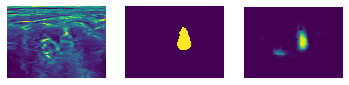


Iteration 99, loss = 0.030517745729170438
Validation loss = 0.05588781679066964

Iteration 199, loss = 0.01991076190159613
Validation loss = 0.04251543375338671

Iteration 299, loss = 0.20048080341223595
Validation loss = 0.017746051390280827

Iteration 399, loss = 0.05864468942645391
Validation loss = 0.07648027511574028

Iteration 499, loss = 0.044391436843504814
Validation loss = 0.057418571961433434

Iteration 599, loss = 0.03860805846538108
Validation loss = 0.1143760372501024

Iteration 699, loss = 0.07547111239190803
Validation loss = 0.0364388074295391

Iteration 799, loss = 0.018753968740497243
Validation loss = 0.1654575885036678

Iteration 899, loss = 0.056764440602399234
Validation loss = 0.019977112508743934

Iteration 999, loss = 0.027007282027723397
Validation loss = 0.02561217708987219

After 18 epochs: loss = 0.027007282027723397
Validation loss = 0.02985701042070259


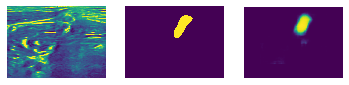


Iteration 99, loss = 0.055640132577020884
Validation loss = 0.05969034991481588

Iteration 199, loss = 0.023959166651510357
Validation loss = 0.07293212908570285

Iteration 299, loss = 0.052475204237606266
Validation loss = 0.057118582402427634

Iteration 399, loss = 0.04160873148524699
Validation loss = 0.02183397930510835

Iteration 499, loss = 0.04918316305355677
Validation loss = 0.05448945767860268

Iteration 599, loss = 0.04040416841919032
Validation loss = 0.058731113788979175

Iteration 699, loss = 0.0664478175195046
Validation loss = 0.05673173163248414

Iteration 799, loss = 0.08675279000263525
Validation loss = 0.03186633298884351

Iteration 899, loss = 0.04392950888882167
Validation loss = 0.02970510296071291

Iteration 999, loss = 0.05897766047645904
Validation loss = 0.0455563455703913

After 19 epochs: loss = 0.05897766047645904
Validation loss = 0.017609341772626717


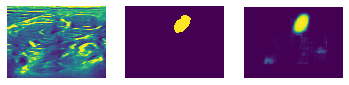


Iteration 99, loss = 0.044514010356495805
Validation loss = 0.033557590827710815

Iteration 199, loss = 0.020127679407089833
Validation loss = 0.07310932404173487

Iteration 299, loss = 0.022269644573391898
Validation loss = 0.01886490065533542

Iteration 399, loss = 0.023806917662878273
Validation loss = 0.02902222425565164

Iteration 499, loss = 0.01894271915451073
Validation loss = 0.01883397832031205

Iteration 599, loss = 0.05478218363116642
Validation loss = 0.09186494900432564

Iteration 699, loss = 0.06839343533373571
Validation loss = 0.02397627915056537

Iteration 799, loss = 0.0802437099436716
Validation loss = 0.16229132094664628

Iteration 899, loss = 0.02620835866641425
Validation loss = 0.0566425531543734

Iteration 999, loss = 0.0372792347614023
Validation loss = 0.02063342650690786

After 20 epochs: loss = 0.0372792347614023
Validation loss = 0.15083086002818685


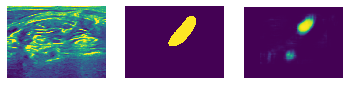


CPU times: user 1h 25min 18s, sys: 32min 45s, total: 1h 58min 3s
Wall time: 1h 47min 51s


In [178]:
%%time
# optimizer = optim.SGD(unet.parameters(),
#                       lr=0.001,
#                       momentum=0.7,
#                       weight_decay=0.01,
#                       dampening=0,
#                       nesterov=True)

optimizer = optim.Adam(unet.parameters(), lr=0.00001)

train(unet, optimizer, loader_train, loader_val, epochs=20, print_every=100)

In [185]:
torch.save(unet.state_dict(), os.path.join(MODEL_PATH, 'unet_epochs20.pth'))

## Generate submission

In [182]:
%%time
testset = USNSDataset(os.path.join(DATA_PATH, 'test'), train=False, transform=transform, mask_transform=transform_mask)
loader_test = DataLoader(testset, batch_size=4)

fname = datetime.now().strftime('%Y%m%d_%H%M%S') + '.csv'
subms_path = os.path.join(SUBMS_PATH, fname)

generate_submission(unet, loader_test, subms_path)

CPU times: user 2min 50s, sys: 59.2 s, total: 3min 49s
Wall time: 3min 20s


In [179]:
x, y = next(iter(loader_train))

In [180]:
with torch.no_grad():
    pred_y = torch.sigmoid(unet(x.to(device)))
    pred_y = pred_y.cpu()

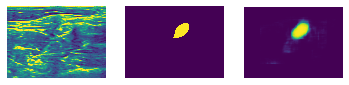

In [181]:
def show_imgs(imglist):
    f, axarr = plt.subplots(1, len(imglist))
    with torch.no_grad():
        for ii, data in enumerate(imglist):
            axarr[ii].axis('off')
            axarr[ii].imshow(data)
    plt.show()

show_imgs([x[0, 0], y[0, 0], pred_y[0,0]])